In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
 <a href="javascript:code_toggle()">expand</a>.''')

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
pd.options.display.max_rows = 999
import numpy as np
import statsmodels.api as sm
from patsy import dmatrices

In [3]:
FeatureTrain = pd.read_csv('./data/dengue_features_train.csv',parse_dates = ['week_start_date'])
TargetTrain = pd.read_csv('./data/dengue_labels_train.csv' )
FeatureTest = pd.read_csv('./data/dengue_features_test.csv',parse_dates = ['week_start_date'])
Answersheet = pd.read_csv('./data/submission_format.csv' )

#                                  Presentation Data Exploration

In [4]:
panel = TargetTrain.merge(FeatureTrain,on = ['city','year','weekofyear'] ,how = 'outer') 
 
kelvin = ['reanalysis_air_temp_k', 'reanalysis_avg_temp_k',   \
          'reanalysis_max_air_temp_k','reanalysis_min_air_temp_k','reanalysis_dew_point_temp_k']
panel.loc[:,kelvin] = panel.loc[:,kelvin]-273.15# kelvin to C
FeatureTest.loc[:,kelvin] =FeatureTest.loc[:,kelvin]-273.15# kelvin to C
panel.columns
timeid = ['year', 'weekofyear']
green = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']
precipitation  =['precipitation_amt_mm','reanalysis_sat_precip_amt_mm','station_precip_mm','reanalysis_precip_amt_kg_per_m2',]
avg_temp = ['reanalysis_air_temp_k', 'reanalysis_avg_temp_k',  'station_avg_temp_c' ]
min_temp = ['station_min_temp_c','reanalysis_min_air_temp_k']
max_temp = ['station_max_temp_c','reanalysis_max_air_temp_k']
dtr =  ['reanalysis_tdtr_k', 'station_diur_temp_rng_c']
humid = ['reanalysis_dew_point_temp_k','reanalysis_specific_humidity_g_per_kg', 'reanalysis_relative_humidity_percent']
selected = humid + dtr + max_temp +min_temp +avg_temp +precipitation +timeid+green + ['city','total_cases','week_start_date']
features_selected= humid + dtr + max_temp +min_temp +avg_temp +precipitation +timeid+green  
panel = panel.loc[:,selected]

 
 


In [5]:
 
def get_data_panel(panel,city_name):
    panel_train =  panel.loc[panel.city == city_name].interpolate()  .set_index('week_start_date').copy().drop(['city'],axis = 1).copy()
    
    panel_test = FeatureTest.loc[FeatureTest.city == city_name].interpolate().set_index('week_start_date').copy().drop('city',axis = 1)
    panel_test['total_cases'] = np.nan 
    train_len = len(panel_test['total_cases'])
    panel = pd.concat([panel_train,panel_test],sort = False)
    
    
    panel['green_s']  = panel.loc[:,green[:2]].mean(1)
    panel['green_n']  = panel.loc[:,green[2:]].mean(1) 
    panel['green']  = panel.loc[:,green ].mean(1) 

    panel  = panel 
    return panel,train_len

panel_sj,len_sj = get_data_panel(panel,'sj')
panel_iq,len_iq = get_data_panel(panel,'iq')

def min_max(data):
     
    return (data - data.min())/(data .max()- data.min())



from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier

drops = ['reanalysis_specific_humidity_g_per_kg']  + green +\
['reanalysis_sat_precip_amt_mm','reanalysis_avg_temp_k','year','weekofyear','total_cases'] 

def append_shift(left,right,selected,shift,smooth =52):
    new_names = []
    right = right.copy().apply(lambda x : x.clip(x.quantile(0.05),x.quantile(0.95)),axis = 0)
    for name in selected:
        new_name = name + '_shift_' +str(shift)+'_smooth_' + str(smooth)
        new_names.append(new_name)
 
        left[new_name] = right.rolling(smooth     ).mean().shift(shift).loc[:,name ]
    return left

def append_diff(left,right,selected,diff,smooth =52):
    new_names = []
    right = right.copy().apply(lambda x : x.clip(x.quantile(0.05),x.quantile(0.95)),axis = 0)
    for name in selected:
        new_name = name + '_diff_'  +'_smooth_' + str(smooth)
        new_names.append(new_name)
 
        left[new_name] = right.diff(1).rolling(smooth   ).mean().loc[:,name ]
    return left
 
def de_season_tri(series):
    
    target = series.name
    series = pd.DataFrame(series.copy())
    series["season_sin"] = np.sin(series.index.weekofyear/53*6.2831)
    series["season_cos"] = np.cos(series.index.weekofyear/53*6.2831)


    X_out = series.drop(target,axis = 1) 
    X_out  = sm.add_constant(X_out) 




    train_df = series.dropna()
    train_y = train_df  .loc[:,target]
    train_y =train_y.clip(train_y.quantile(0.05),train_y.quantile(0.95))
    train_X = train_df  .drop(target,axis = 1)
    train_X = sm.add_constant(train_X)
    model = sm.OLS(train_y,train_X)
    res = model.fit()
    return  series.loc[:,target] .ravel()/res  .predict(X_out) .ravel() - 1


def get_season_tri(series):
    
    target = series.name
    series = pd.DataFrame(series.copy())
    series["season_sin"] = np.sin(series.index.weekofyear/53*6.2831)
    series["season_cos"] = np.cos(series.index.weekofyear/53*6.2831)


    X_out = series.drop(target,axis = 1) 
    X_out  = sm.add_constant(X_out) 




    train_df = series.dropna()
    train_y = train_df  .loc[:,target]
    train_y =train_y.clip(train_y.quantile(0.05),train_y.quantile(0.95))
    train_X = train_df  .drop(target,axis = 1)
    train_X = sm.add_constant(train_X)
    model = sm.OLS(train_y,train_X)
    res = model.fit()
    return   res  .predict(X_out) .ravel()  



 

panel_sj,len_sj = get_data_panel(panel,'sj')
 
panel_iq,len_iq = get_data_panel(panel,'iq')
 

## Modling Approches
     Based on our analysis from EDA, we can learn:
         1. The series pattern is seasonaland autoarresive with trend and jump
         2. No any indivdual factor shows high correlation for prediction the series other than seasonality
         3. Time span is very long, magnitude also changing with time.
     Approaches:
         1. Predict seasonal adjust series and re-scaled the prediction series
         2. Directly predict original series 
     Model:
         1. Random forest with boostrapping 
         2. Grandient Boost 
         3. GLM model with parsimonious inputs
         4 .LSTM with parsimonious inputs
    So there are 8 models in total  X  2 approaches
    Finally, we avarage all models for the final output. 
        
     
         

## Random Forest - Approach 1

In [6]:
panel_sj_selected  = panel_sj.loc[:,['total_cases']]
panel_iq_selected  = panel_iq.loc[:,['total_cases']] 
np.random.seed(10)
def data_process_random_forest(panel,panel_candidate ):
    
    """
    Make sure it is at least forward filled
    """
    panel = append_shift(panel,panel_candidate,\
          panel_candidate.columns,0,52)
    
    panel = append_shift(panel,panel_candidate,\
          panel_candidate.columns,0,20)
    
    panel = append_diff(panel,panel_candidate,\
          panel_candidate.columns,26,26)
    
    
    # de - seasons
    de_seasons = panel_candidate.apply(de_season_tri,axis = 0)
    new_names = [name +'_ds' for name in de_seasons.columns]
    de_seasons.columns = new_names
    
    
    panel = append_shift(panel,de_seasons,\
          de_seasons.columns,0,52)
    
    panel = append_shift(panel,de_seasons,\
          de_seasons.columns,0,10)
    
    panel = append_diff(panel,de_seasons,\
          de_seasons.columns,26,30)
 
    return panel .fillna(method = 'ffill')

panel_sj_selected =  data_process_random_forest(panel_sj_selected,panel_sj.drop(drops,axis = 1))
panel_iq_selected =  data_process_random_forest(panel_iq_selected,panel_iq.drop(drops,axis = 1)) 
#panel_sj_selected['season'] = get_season_tri(panel_sj_selected.total_cases )
#panel_iq_selected['season'] = get_season_tri(panel_iq_selected.total_cases )
train_y_sj, train_X_sj =   panel_sj_selected  .iloc[: -len_sj].dropna().loc[:,'total_cases'],\
                            panel_sj_selected .iloc[: -len_sj] .dropna().drop('total_cases',axis = 1)  
 
train_y_iq, train_X_iq =   panel_iq_selected .iloc[60: -len_iq].dropna() .loc[:,'total_cases'],\
                            panel_iq_selected.iloc[60: -len_iq] .dropna() .drop('total_cases',axis = 1)  
                         

test_X_sj = panel_sj_selected.drop('total_cases',axis = 1)  .iloc[-len_sj: ]
test_X_iq = panel_iq_selected.drop('total_cases',axis = 1)  .iloc[-len_iq: ]



rf_sj = RandomForestRegressor(n_estimators=200,    max_features='auto',
                                         max_depth=4, criterion='mae',   warm_start=True, \
                                )
rf_sj.fit( train_X_sj ,train_y_sj )
rf_iq = RandomForestRegressor(n_estimators=200, max_features='auto',
                                         max_depth=4, criterion='mae',  warm_start=True)

rf_iq.fit(train_X_iq  ,train_y_iq )


sj_predictions =  pd.Series(np.round(rf_sj . predict( test_X_sj)).astype(int) ) 
iq_predictions =  pd.Series(np.round(rf_iq .predict(test_X_iq )).astype(int) )


 



D:\Anaconda3\envs\interview_env\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


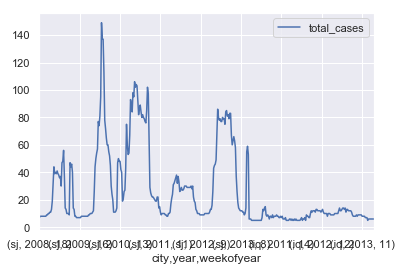

In [7]:
def submission( sj_predictions,iq_predictions):
    sj_predictions =  pd.Series(np.round(sj_predictions  ).round().astype(int) )
    iq_predictions =  pd.Series(np.round(iq_predictions )  .round().astype(int) )
    submission = pd.read_csv("./data/submission_format.csv", index_col=[0, 1, 2])
    submission.total_cases =np.concatenate([sj_predictions, iq_predictions])
   
    submission.to_csv("./data/submission_rf.csv")
    return submission
    
submission(sj_predictions ,iq_predictions).plot()

### XGBoost 

D:\Anaconda3\envs\interview_env\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


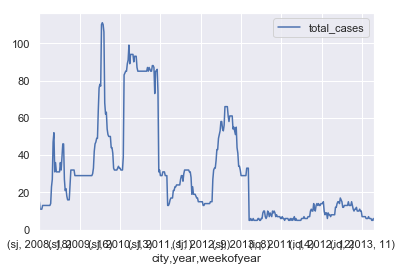

In [8]:
from xgboost import XGBRegressor
 
 
 
xgb_sj = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=1,
             importance_type='gain', learning_rate=0.02, max_delta_step=0,
             max_depth=2, min_child_weight=2, missing=None,  
             n_jobs=4, nthread=None, objective='reg:squarederror',
             random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)


xgb_sj.fit( train_X_sj ,train_y_sj.clip(0,250) )


xgb_iq = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=1,
             importance_type='gain', learning_rate=0.02, max_delta_step=0,
             max_depth=2, min_child_weight=2, missing=None,  
             n_jobs=4, nthread=None, objective='reg:squarederror',
             random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

xgb_iq.fit(train_X_iq  ,train_y_iq.clip(0,40))


sj_predictions =  pd.Series(np.round(xgb_sj . predict( test_X_sj)).astype(int) ) 
iq_predictions =  pd.Series(np.round(xgb_iq .predict(test_X_iq )).astype(int) ) 

 
def submission( sj_predictions,iq_predictions):
    sj_predictions =  pd.Series(np.round(sj_predictions  ).round().astype(int) )
    iq_predictions =  pd.Series(np.round(iq_predictions )  .round().astype(int) )
    submission = pd.read_csv("./data/submission_format.csv", index_col=[0, 1, 2])
    submission.total_cases =np.concatenate([sj_predictions, iq_predictions])
   
    submission.to_csv("./data/submission_xgb.csv")
    return submission
    
submission(sj_predictions ,iq_predictions).plot() 

## GLM:
    1. Using the feature selection from previous model, we can build a simpler linear model using XGboost
    2. What's the feature size? Though we have 936 observations, but they are not really independent. With seasonality, the degree of       freedom is even smaller(As a naive rule: 900 / 12(season) / 10 = 7   )
    3. Seasonality and constant need to be expressed explicityly 

###  Feature importances for SJ (Top 50)

In [9]:
rf_importance_sj = pd.Series(rf_sj.feature_importances_,index = train_X_sj.columns).sort_values(ascending = True).iloc[:50]
xgb_importance_sj = pd.Series(xgb_sj.feature_importances_,index = train_X_sj.columns).sort_values(ascending = True).iloc[:50]
selected = xgb_importance_sj .index.intersection(rf_importance_sj .index)
selected_sj =selected 
rf_importance_iq = pd.Series(rf_iq.feature_importances_,index = train_X_iq.columns).sort_values(ascending = True).iloc[:50]
xgb_importance_iq = pd.Series(xgb_iq.feature_importances_,index = train_X_iq.columns).sort_values(ascending = True).iloc[:50]

selected_iq =  xgb_importance_iq .index.intersection(rf_importance_iq .index) 

In [10]:
import statsmodels.api as sm
def normalize(df, how ):
    if how == 'z':
        return (df - df.mean())/(df.std())
    if how == 'r':
        return (df - df.min())/(df.max() - df.min())
    
    
    
train_y_sj, train_X_sj =   panel_sj_selected  .iloc[: -len_sj].dropna().loc[:,'total_cases'],\
                             normalize(panel_sj_selected,'z' ).iloc[: -len_sj] .dropna().loc[:,selected_sj] 
 
train_y_iq, train_X_iq =   panel_iq_selected .iloc[60: -len_iq].dropna() .loc[:,'total_cases'],\
                             normalize(panel_iq_selected,'z').iloc[60: -len_iq] .dropna().loc[:,selected_iq] 
                         
train_X_sj  = sm.add_constant(train_X_sj )
train_X_iq  = sm.add_constant(train_X_iq )


test_X_sj = panel_sj_selected.loc[:,selected_sj ]  .iloc[-len_sj: ]
test_X_iq = panel_iq_selected.loc[:,selected_iq  ]  .iloc[-len_iq: ]


test_X_sj  = sm.add_constant(test_X_sj )
test_X_iq  = sm.add_constant(test_X_iq )

D:\Anaconda3\envs\interview_env\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


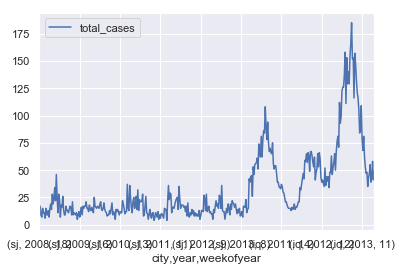

In [16]:
glm_sj = XGBRegressor(base_score=0.5, booster='gblinear', colsample_bytree = 0.3,subsample = 0.5,\
               learning_rate=0.02, 
                  
               objective='count:poisson',
               reg_lambda=3, scale_pos_weight=1)


glm_sj.fit( train_X_sj ,train_y_sj.clip(0,250) )


glm_iq = XGBRegressor(   booster='gblinear',  colsample_bytree = 0.3,subsample = 0.5,\
            learning_rate=0.02,  
            
             n_jobs=4, nthread=None, objective='count:poisson',
            reg_lambda=10 )

glm_iq.fit(train_X_iq  ,train_y_iq.clip(0,40))


sj_predictions =  pd.Series(np.round(glm_sj . predict( test_X_sj)).astype(int) ) 
iq_predictions =  pd.Series(np.round(glm_iq .predict(test_X_iq )).astype(int) ) 

 
def submission( sj_predictions,iq_predictions):
    sj_predictions =  pd.Series(np.round(sj_predictions  ).round().astype(int) )
    iq_predictions =  pd.Series(np.round(iq_predictions )  .round().astype(int) )
    submission = pd.read_csv("./data/submission_format.csv", index_col=[0, 1, 2])
    submission.total_cases =np.concatenate([sj_predictions, iq_predictions])
   
    submission.to_csv("./data/submission_glm.csv")
    return submission
    
submission(sj_predictions ,iq_predictions).plot() 

## Now, avaraging these three models

In [12]:
glm_submissions = pd.read_csv("./data/submission_glm.csv", index_col=[0, 1, 2]) 
rf_submissions = pd.read_csv("./data/submission_rf.csv", index_col=[0, 1, 2])
xgb_submissions = pd.read_csv("./data/submission_xgb.csv", index_col=[0, 1, 2])
avg_submissions  = np.round(( rf_submissions +xgb_submissions)/2).astype(int)
avg_submissions.to_csv("./data/submission_avg.csv")